In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import cftime
import calendar
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.ticker as mticker
from matplotlib.colors import TwoSlopeNorm
import imageio
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature

### Reading in the data files

Reading it the different files, then changing the years to normal year and not a proplectic calendar. Also splitting into different seasons in case I need that for later. 

In [2]:
t2m_wf1 = xr.open_dataset('/nird/datalake/NS1004K/elihho/tes0004_echam6_BOT_mm_0_1850_var167.nc')
t2m_wof1 = xr.open_dataset('/nird/datalake/NS1004K/elihho/slo0059_echam6_BOT_mm_0_1850_var167.nc')

tas_orb_GHG = xr.open_dataset('slo0043_echam6_BOT_mm_1001-8850_167_NH.nc')
tas_all_forcing = xr.open_dataset('slo0042+slo0046+slo0050_echam6_BOT_mm_1001_8850_167_NH.nc')

In [3]:
# For t2m_wf
n_months_wf = t2m_wf1.sizes['time']
years_wf = np.floor_divide(np.arange(n_months_wf), 12)
months_wf = (np.remainder(np.arange(n_months_wf), 12) + 1)
cftime_time_wf = [cftime.DatetimeNoLeap(int(y), int(m), 1) for y, m in zip(years_wf, months_wf)]
t2m_wf = t2m_wf1.assign_coords(time=("time", cftime_time_wf))

# For t2m_wof
n_months_wof = t2m_wof1.sizes['time']
years_wof = np.floor_divide(np.arange(n_months_wof), 12)
months_wof = (np.remainder(np.arange(n_months_wof), 12) + 1)
cftime_time_wof = [cftime.DatetimeNoLeap(int(y), int(m), 1) for y, m in zip(years_wof, months_wof)]
t2m_wof = t2m_wof1.assign_coords(time=("time", cftime_time_wof))

# For orb_GHG
n_months_wf = tas_orb_GHG.sizes['time']
start_year_wf = 1850 - (n_months_wf // 12)  # reverse from last year
years_wf = np.floor_divide(np.arange(n_months_wf), 12) + start_year_wf
months_wf = (np.remainder(np.arange(n_months_wf), 12) + 1)
cftime_time_wf = [cftime.DatetimeNoLeap(int(y), int(m), 1) for y, m in zip(years_wf, months_wf)]
tas_orb_GHG = tas_orb_GHG.assign_coords(time=("time", cftime_time_wf))

# For all_forcing 
n_months_wof = tas_all_forcing.sizes['time']
start_year_wof = 1850 - (n_months_wof // 12)
years_wof = np.floor_divide(np.arange(n_months_wof), 12) + start_year_wof
months_wof = (np.remainder(np.arange(n_months_wof), 12) + 1)
cftime_time_wof = [cftime.DatetimeNoLeap(int(y), int(m), 1) for y, m in zip(years_wof, months_wof)]
tas_all_forcing = tas_all_forcing.assign_coords(time=("time", cftime_time_wof))

In [4]:
# Split seasons
t2m_wf_DJF = t2m_wf['var167'][0::4,:,:]
t2m_wf_JJA = t2m_wf['var167'][2::4,:,:]

t2m_wof_DJF = t2m_wof['var167'][0::4,:,:]
t2m_wof_JJA = t2m_wof['var167'][2::4,:,:]

tas_orb_GHG_DJF = tas_orb_GHG['var167'][0::4,:,:]
tas_orb_GHG_JJA = tas_orb_GHG['var167'][2::4,:,:]

tas_all_forcing_DJF = tas_all_forcing['var167'][0::4,:,:]
tas_all_forcing_JJA = tas_all_forcing['var167'][2::4,:,:]

In [5]:
t2m_wf_tot = t2m_wf.sel(time=slice(f'0000-01-01', f'1850-12-31'))
t2m_wof_tot = t2m_wof.sel(time=slice(f'0000-01-01', f'1850-12-31'))

tas_orb_GHG_tot = tas_orb_GHG.sel(time=slice(f'0000-01-01', f'1850-12-31'))
tas_all_forcing_tot = tas_all_forcing.sel(time=slice(f'0000-01-01', f'1850-12-31'))

### Global

In [6]:
rolling_years = 5
rolling_months = rolling_years * 12

In [7]:
# Simple average
global_mean_wf = t2m_wf_tot['var167'].mean(dim=['lat', 'lon'])
global_mean_wof = t2m_wof_tot['var167'].mean(dim=['lat', 'lon'])

smoothed_global_mean_wf = global_mean_wf.rolling(time=rolling_months, center=True).mean()
smoothed_global_mean_wof = global_mean_wof.rolling(time=rolling_months, center=True).mean()

In [8]:
orb_GHG = tas_orb_GHG_tot['var167'].mean(dim=['lat', 'lon'])
all_forcing = tas_all_forcing_tot['var167'].mean(dim=['lat', 'lon'])

orb_GHG_smooth = orb_GHG.rolling(time=rolling_months, center=True).mean()
all_forcing_smooth = all_forcing.rolling(time=rolling_months, center=True).mean()

### NH

In [9]:
nh_lat = slice(89, 0)

nh_wf = t2m_wf_tot['var167'].sel(lat=nh_lat).mean(dim=['lat', 'lon'])
nh_wof = t2m_wof_tot['var167'].sel(lat=nh_lat).mean(dim=['lat', 'lon'])

# Smooth with rolling mean
nh_smoothed_wf = nh_wf.rolling(time=rolling_months, center=True).mean()
nh_smoothed_wof = nh_wof.rolling(time=rolling_months, center=True).mean()

In [10]:
orb_GHG_NH = tas_orb_GHG_tot['var167'].sel(lat=nh_lat).mean(dim=['lat', 'lon'])
all_forcing_NH = tas_all_forcing_tot['var167'].sel(lat=nh_lat).mean(dim=['lat', 'lon'])

nh_orb_GHG_smooth = orb_GHG_NH.rolling(time=rolling_months, center=True).mean()
nh_all_forcing_smooth = all_forcing_NH.rolling(time=rolling_months, center=True).mean()

### Scandinvia

In [11]:
scand_lat = slice(89, 50)
scand_lon = slice(-10, 50)

scand_wf = t2m_wf_tot['var167'].sel(lat=scand_lat, lon = scand_lon).mean(dim=['lat', 'lon'])
scand_wof = t2m_wof_tot['var167'].sel(lat=scand_lat, lon = scand_lon).mean(dim=['lat', 'lon'])

# Smooth with rolling mean
scand_smoothed_wf = scand_wf.rolling(time=rolling_months, center=True).mean()
scand_smoothed_wof = scand_wof.rolling(time=rolling_months, center=True).mean()

In [12]:
scand_orb_GHG = tas_orb_GHG_tot['var167'].sel(lat=scand_lat, lon = scand_lon).mean(dim=['lat', 'lon'])
scand_all_forcing = tas_all_forcing_tot['var167'].sel(lat=scand_lat, lon = scand_lon).mean(dim=['lat', 'lon'])

scand_orb_GHG_smooth = scand_orb_GHG.rolling(time=rolling_months, center=True).mean()
scand_all_forcing_smooth = scand_all_forcing.rolling(time=rolling_months, center=True).mean()

### Plotting the different regions from 0-1850 (marking 1250-1750 as LIA)

In [13]:
# Extract decimal years from cftime time coordinate
def cftime_to_decimal_year(time_array):
    years = np.array([t.year for t in time_array])
    months = np.array([t.month for t in time_array])
    # Approximate decimal year (month/12)
    decimal_years = years + (months - 1) / 12
    return decimal_years

x_wf = cftime_to_decimal_year(smoothed_global_mean_wf['time'].values)
x_wof = cftime_to_decimal_year(smoothed_global_mean_wof['time'].values)
x_nh_wf = cftime_to_decimal_year(nh_smoothed_wf['time'].values)
x_nh_wof = cftime_to_decimal_year(nh_smoothed_wof['time'].values)
x_scand_wf = cftime_to_decimal_year(scand_smoothed_wf['time'].values)
x_scand_wof = cftime_to_decimal_year(scand_smoothed_wof['time'].values)

x_orb_GHG = cftime_to_decimal_year(orb_GHG_smooth['time'].values)
x_all_forcing = cftime_to_decimal_year(all_forcing_smooth['time'].values)
x_nh_orb_GHG = cftime_to_decimal_year(nh_orb_GHG_smooth['time'].values)
x_nh_all_forcing = cftime_to_decimal_year(nh_all_forcing_smooth['time'].values)
x_scand_orb_GHG = cftime_to_decimal_year(scand_orb_GHG_smooth['time'].values)
x_scand_all_forcing = cftime_to_decimal_year(scand_all_forcing_smooth['time'].values)

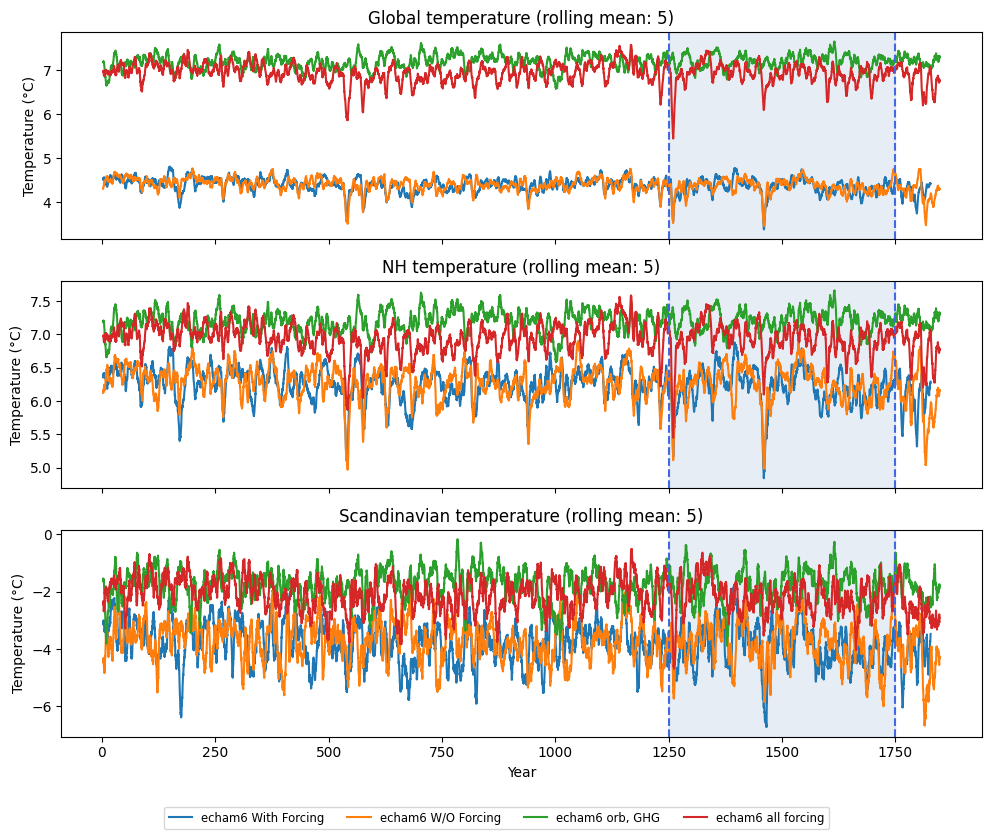

In [14]:
fig, ax = plt.subplots(3,1, figsize=(10,8), sharex = True)

start_time = 1250
end_time = 1750

ax[0].plot(x_wf, smoothed_global_mean_wf - 273.15, label='echam6 With Forcing')
ax[0].plot(x_wof, smoothed_global_mean_wof - 273.15, label='echam6 W/O Forcing')
ax[0].plot(x_orb_GHG, orb_GHG_smooth - 273.15, label='echam6 orb, GHG')
ax[0].plot(x_all_forcing, all_forcing_smooth - 273.15, label='echam6 all forcing')
ax[0].axvline(start_time, color='royalblue', linestyle='--')
ax[0].axvline(end_time, color='royalblue', linestyle='--')
ax[0].axvspan(start_time, end_time, color='lightsteelblue', alpha=0.3)
ax[0].set_ylabel('Temperature (°C)')
ax[0].set_title(f'Global temperature (rolling mean: {rolling_years})')

ax[1].plot(x_nh_wf, nh_smoothed_wf - 273.15, label='echam6 With Forcing')
ax[1].plot(x_nh_wof, nh_smoothed_wof - 273.15, label='echam6 W/O Forcing')
ax[1].plot(x_nh_orb_GHG, nh_orb_GHG_smooth - 273.15, label='echam6 orb, GHG')
ax[1].plot(x_nh_all_forcing, nh_all_forcing_smooth - 273.15, label='echam6 all forcing')
ax[1].axvline(start_time, color='royalblue', linestyle='--')
ax[1].axvline(end_time, color='royalblue', linestyle='--')
ax[1].axvspan(start_time, end_time, color='lightsteelblue', alpha=0.3)
ax[1].set_ylabel('Temperature (°C)')
ax[1].set_title(f'NH temperature (rolling mean: {rolling_years})')

ax[2].plot(x_scand_wf, scand_smoothed_wf - 273.15, label='echam6 With Forcing')
ax[2].plot(x_scand_wof, scand_smoothed_wof - 273.15, label='echam6 W/O Forcing')
ax[2].plot(x_scand_orb_GHG, scand_orb_GHG_smooth - 273.15, label='echam6 orb, GHG')
ax[2].plot(x_scand_all_forcing, scand_all_forcing_smooth - 273.15, label='echam6 all forcing')
ax[2].axvline(start_time, color='royalblue', linestyle='--')
ax[2].axvline(end_time, color='royalblue', linestyle='--')
ax[2].axvspan(start_time, end_time, color='lightsteelblue', alpha=0.3)
ax[2].set_xlabel('Year')
ax[2].set_ylabel('Temperature (°C)')
ax[2].set_title(f'Scandinavian temperature (rolling mean: {rolling_years})')

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=6,
    fontsize='small',
    frameon=True
)
plt.tight_layout()
plt.show()

### Anomalies of the same thing

### Global

In [15]:
baseline_wf = t2m_wf_tot['var167'].mean(dim = 'time')
anomaly_wf = t2m_wf_tot['var167'] - baseline_wf
smoothed_anomaly_wf = anomaly_wf.rolling(time=rolling_months, center=True).mean()
baseline_wof = t2m_wof_tot['var167'].mean(dim = ['lat', 'lon'])
anomaly_wof = t2m_wof_tot['var167'] - baseline_wof
smoothed_anomaly_wof = anomaly_wof.rolling(time=rolling_months, center=True).mean()

baseline_orb_GHG = tas_orb_GHG_tot['var167'].mean(dim = 'time')
anomaly_orb_GHG = tas_orb_GHG_tot['var167'] - baseline_orb_GHG
smoothed_anomaly_orb_GHG = anomaly_orb_GHG.rolling(time=rolling_months, center=True).mean()
baseline_all_forcing = tas_all_forcing_tot['var167'].mean(dim = ['lat', 'lon'])
anomaly_all_forcing = tas_all_forcing_tot['var167'] - baseline_all_forcing
smoothed_anomaly_all_forcing = anomaly_all_forcing.rolling(time=rolling_months, center=True).mean()

### NH

In [16]:
baseline_nh_wf = t2m_wf_tot['var167'].sel(lat=nh_lat).mean(dim = 'time')
anomaly_nh_wf = t2m_wf_tot['var167'].sel(lat=nh_lat) - baseline_nh_wf
smoothed_anomaly_nh_wf = anomaly_nh_wf.rolling(time=rolling_months, center=True).mean()
baseline_nh_wof = t2m_wof_tot['var167'].sel(lat=nh_lat).mean(dim = ['lat', 'lon'])
anomaly_nh_wof = t2m_wof_tot['var167'].sel(lat=nh_lat) - baseline_nh_wof
smoothed_anomaly_nh_wof = anomaly_nh_wof.rolling(time=rolling_months, center=True).mean()

baseline_nh_orb_GHG = tas_orb_GHG_tot['var167'].sel(lat=nh_lat).mean(dim = 'time')
anomaly_nh_orb_GHG = tas_orb_GHG_tot['var167'] - baseline_nh_orb_GHG
smoothed_nh_anomaly_orb_GHG = anomaly_nh_orb_GHG.rolling(time=rolling_months, center=True).mean()
baseline_nh_all_forcing = tas_all_forcing_tot['var167'].sel(lat=nh_lat).mean(dim = ['lat', 'lon'])
anomaly_nh_all_forcing = tas_all_forcing_tot['var167'] - baseline_nh_all_forcing
smoothed_nh_anomaly_all_forcing = anomaly_nh_all_forcing.rolling(time=rolling_months, center=True).mean()

### Scandinavia

In [17]:
baseline_scand_wf = t2m_wf_tot['var167'].sel(lat=scand_lat, lon = scand_lon).mean(dim='time')
anomaly_scand_wf = t2m_wf_tot['var167'].sel(lat=scand_lat, lon = scand_lon) - baseline_scand_wf
smoothed_anomaly_scand_wf = anomaly_scand_wf.rolling(time=rolling_months, center=True).mean()
baseline_scand_wof = t2m_wof_tot['var167'].sel(lat=scand_lat, lon = scand_lon).mean(dim = ['lat', 'lon'])
anomaly_scand_wof = t2m_wof_tot['var167'].sel(lat=scand_lat, lon = scand_lon) - baseline_scand_wof
smoothed_anomaly_scand_wof = anomaly_scand_wof.rolling(time=rolling_months, center=True).mean()

baseline_scand_orb_GHG = tas_orb_GHG_tot['var167'].sel(lat=scand_lat, lon = scand_lon).mean(dim ='time')
anomaly_scand_orb_GHG = tas_orb_GHG_tot['var167'].sel(lat=scand_lat, lon = scand_lon) - baseline_scand_orb_GHG
smoothed_scand_anomaly_orb_GHG = anomaly_scand_orb_GHG.rolling(time=rolling_months, center=True).mean()
baseline_scand_all_forcing = tas_all_forcing_tot['var167'].sel(lat=scand_lat, lon = scand_lon).mean(dim = ['lat', 'lon'])
anomaly_scand_all_forcing = tas_all_forcing_tot['var167'].sel(lat=scand_lat, lon = scand_lon) - baseline_scand_all_forcing
smoothed_scand_anomaly_all_forcing = anomaly_scand_all_forcing.rolling(time=rolling_months, center=True).mean()

### Plot

In [18]:
x_wf = cftime_to_decimal_year(smoothed_anomaly_wf['time'].values)
x_wof = cftime_to_decimal_year(smoothed_anomaly_wof['time'].values)
x_nh_wf = cftime_to_decimal_year(smoothed_anomaly_nh_wf['time'].values)
x_nh_wof = cftime_to_decimal_year(smoothed_anomaly_nh_wof['time'].values)
x_scand_wf = cftime_to_decimal_year(smoothed_anomaly_scand_wf['time'].values)
x_scand_wof = cftime_to_decimal_year(smoothed_anomaly_scand_wof['time'].values)

x_orb_GHG = cftime_to_decimal_year(smoothed_anomaly_orb_GHG['time'].values)
x_all_forcing = cftime_to_decimal_year(smoothed_anomaly_all_forcing['time'].values)
x_nh_orb_GHG = cftime_to_decimal_year(smoothed_nh_anomaly_orb_GHG['time'].values)
x_nh_all_forcing = cftime_to_decimal_year(smoothed_nh_anomaly_all_forcing['time'].values)
x_scand_orb_GHG = cftime_to_decimal_year(smoothed_scand_anomaly_orb_GHG['time'].values)
x_scand_all_forcing = cftime_to_decimal_year(smoothed_scand_anomaly_all_forcing['time'].values)

ValueError: x and y can be no greater than 2D, but have shapes (21960,) and (21960, 96, 192)

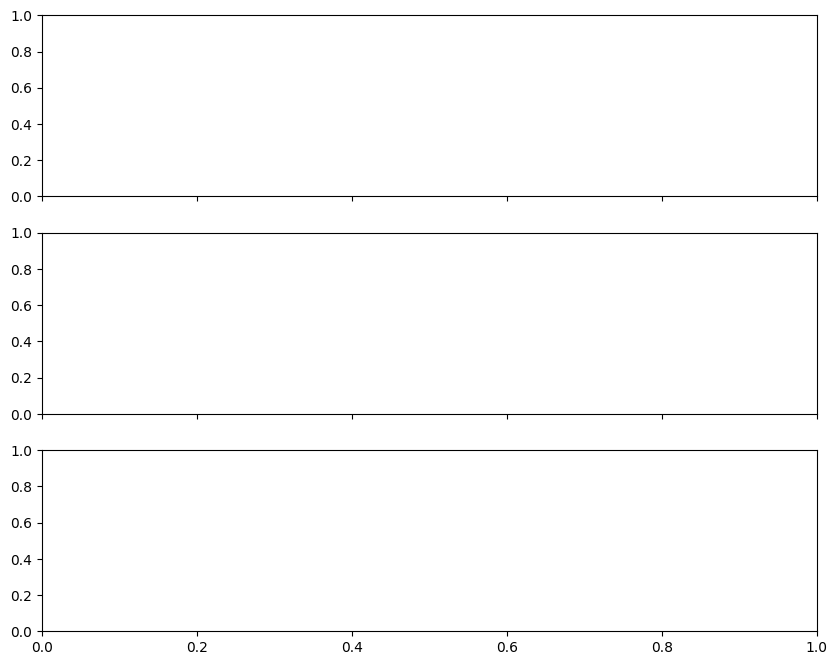

In [19]:
fig, ax = plt.subplots(3,1, figsize=(10,8), sharex = True)

start_time = 1250
end_time = 1750

ax[0].plot(x_wf, smoothed_anomaly_wf, label='echam6 With Forcing')
ax[0].plot(x_wof, smoothed_anomaly_wof, label='echam6 W/O Forcing')
ax[0].plot(x_orb_GHG, amoothed_snoamly_orb_GHG, label='echam6 orb, GHG')
ax[0].plot(x_all_forcing, smoothed_anomaly_all_forcing, label='echam6 all forcing')
ax[0].axvline(start_time, color='royalblue', linestyle='--')
ax[0].axvline(end_time, color='royalblue', linestyle='--')
ax[0].axvspan(start_time, end_time, color='lightsteelblue', alpha=0.3)
ax[0].axhline(0, linestyle='--', color='gray')
ax[0].set_ylabel('Temperature anomaly')
ax[0].set_title(f'Global temperature (rolling mean: {rolling_years})')

ax[1].plot(x_nh_wf, smoothed_anomaly_nh_wf, label='echam6 With Forcing')
ax[1].plot(x_nh_wof, smoothed_anomaly_nh_wof, label='echam6 W/O Forcing')
ax[1].plot(x_nh_orb_GHG, smoothed_nh_anomaly_orb_GHG, label='echam6 orb, GHG')
ax[1].plot(x_nh_all_forcing, amoothed_nh_anomal_all_forcing_smooth, label='echam6 all forcing')
ax[1].axvline(start_time, color='royalblue', linestyle='--')
ax[1].axvline(end_time, color='royalblue', linestyle='--')
ax[1].axvspan(start_time, end_time, color='lightsteelblue', alpha=0.3)
ax[1].axhline(0, linestyle='--', color='gray')
ax[1].set_ylabel('Temperature anomaly')
ax[1].set_title(f'NH temperature (rolling mean: {rolling_years})')

ax[2].plot(x_scand_wf, smoothed_anomaly_scand_wf, label='echam6 With Forcing')
ax[2].plot(x_scand_wof, smoothed_anomaly_scand_wof, label='echam6 W/O Forcing')
ax[2].plot(x_scand_orb_GHG, smoothed_scand_anomaly_orb_GHG_smooth, label='echam6 orb, GHG')
ax[2].plot(x_scand_all_forcing, smoothed_scand_anomaly_all_forcing_smooth, label='echam6 all forcing')
ax[2].axvline(start_time, color='royalblue', linestyle='--')
ax[2].axvline(end_time, color='royalblue', linestyle='--')
ax[2].axvspan(start_time, end_time, color='lightsteelblue', alpha=0.3)
ax[2].axhline(0, linestyle='--', color='gray')
ax[2].set_xlabel('Year')
ax[2].set_ylabel('Temperature anomaly')
ax[2].set_title(f'Scandinavian temperature (rolling mean: {rolling_years})')

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=6,
    fontsize='small',
    frameon=True
)
plt.tight_layout()
plt.show()